<a href="https://colab.research.google.com/github/smlra-kjsce/ML-DL101/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks
<ul>
  <li><a href="">What are convolutional neural networks</a></li>
<ul>

##Building the model

### Adding PyTorch to this notebook and Importing Files

In [0]:
# make sure to enable GPU acceleration! == Done
device = 'cuda'

!pip3 install torch torchvision
!pip install torchviz

#Import Libraries


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from copy import deepcopy
from torchviz import make_dot, make_dot_from_trace

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=12a35599acd74d7e9a3bcf3993c15bc006431ba3eb645f3ac6cdde37d0032cf7
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


###All Paramteres for training the model

In [0]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

###Downloading and pre-processing data

In [0]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21906603.24it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 335428.03it/s]
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5844890.47it/s]                           
8192it [00:00, 130587.80it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


###Defining the model

In [0]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride = 1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride = 1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv3 = nn.Conv2d(32,64, kernel_size=5, stride = 1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        self.x = x
        self.after_conv1 = self.conv1(self.x) 
        self.after_relu1 = F.relu(self.after_conv1)
        self.after_conv2 = self.conv2(self.after_relu1)
        self.after_maxpool2 = F.max_pool2d(self.after_conv2, 2)
        self.after_relu2 = F.relu(self.after_maxpool2)
        self.after_dropout2 = F.dropout(self.after_relu2, p=0.5, training=self.training)
        self.after_conv3 = self.conv3(self.after_dropout2)
        self.after_maxpool3 = F.max_pool2d(self.after_conv3,2)
        self.after_relu3 = F.relu(self.after_maxpool3)
        self.after_dropout3 = F.dropout(self.after_relu3, p=0.5, training=self.training)
        self.after_reshape = self.after_dropout3.view(-1,3*3*64 )
        self.after_fc4 = self.fc1(self.after_reshape)
        self.after_relu4 = F.relu(self.after_fc4)
        self.after_dropout4 = F.dropout(self.after_relu4, training=self.training)
        self.after_fc5 = self.fc2(self.after_dropout4)
        return F.log_softmax(self.after_fc5, dim=1)

###Training and Testing the Model


In [0]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        # print(loss)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
            
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319651
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.307608
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.299467
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.294416
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.286313
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.287686


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2664, Accuracy: 3299/10000 (32%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.276994
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.261916
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.256086
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.256189
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.228010
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.209493

Test set: Average loss: 2.1656, Accuracy: 6251/10000 (62%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.199782
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.170506
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.124279
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.041222
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.973004
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.873237

Test set: Average loss: 1.5402, Accuracy: 7328/10000 (73%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.727988
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.591698
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.502393
Train Epoch: 4 [30000/60000 (50%)]	Loss: 1.363354
Train Epoch: 4 [40000/60000 (67%

###Testing Using Custom Examples

tensor([[    0.0000, -1359.1697,  -482.2861,  -801.7672, -1136.7977,  -526.2972,
          -696.3121,  -883.9150,  -743.1136,  -765.6729]], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


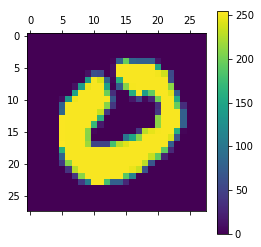

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

model.eval()
example = deepcopy(data.data[25])

if args['cuda']:
    model.cuda()
    example = example.cuda()

example = Variable(example,volatile=True).float().unsqueeze(0).unsqueeze(0)
print(model(example).data)

plt.matshow(data.data[25])
plt.colorbar()

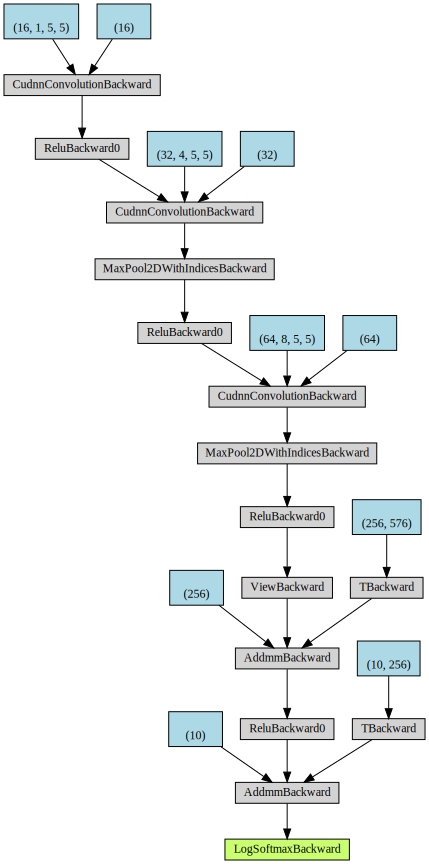

In [0]:
make_dot(model(example))

##Visualizing all layers

###Extracting Layers

In [0]:
all_parameters=np.array(deepcopy(list(model.parameters())))

In [0]:
# Printing Paramter Names
for i in model.named_parameters():
  print(i[0])

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [0]:
for i in range(len(all_parameters)):
  all_parameters[i] = all_parameters[i].cpu().detach().numpy()

In [0]:
layer = 0
print(all_parameters[layer].shape,all_parameters[layer].size)
all_parameters[layer]

(16, 1, 5, 5) 400


array([[[[-2.14212865e-01, -1.87882140e-01, -1.40519291e-02,
          -3.67063284e-02, -4.69096676e-02],
         [-2.03082129e-01, -3.48809361e-02,  9.62384194e-02,
           1.17893852e-01,  1.03401877e-01],
         [-1.44074231e-01, -8.91651809e-02,  1.19560711e-01,
           7.55216107e-02,  1.41721338e-01],
         [ 1.42361656e-01,  1.25321493e-01, -7.27576166e-02,
           2.14470327e-01,  1.12762377e-01],
         [-1.41099721e-01,  1.92377910e-01, -4.13115956e-02,
          -6.26242235e-02, -7.55806454e-03]]],


       [[[-4.80192155e-03,  9.51321870e-02,  2.19093382e-01,
           2.24121794e-01,  1.67219609e-01],
         [ 1.23762779e-01,  1.50269508e-01,  1.58798441e-01,
           3.58631946e-02,  8.26426893e-02],
         [ 2.22898141e-01, -5.46119511e-02,  2.77312975e-02,
          -1.42151549e-01,  7.82742128e-02],
         [ 2.35132892e-02,  1.53005153e-01,  2.04747114e-02,
          -1.74282357e-01,  1.44214079e-01],
         [-2.47692447e-02, -3.58538777e-02

###Plotting the weights

Enter the Layer: 1
Enter the filter number: 1
[[ 0.08596534 -0.07424985  0.04018736  0.02432946 -0.02979402]
 [-0.03057344 -0.07387438  0.07688809  0.09478265 -0.09599309]
 [ 0.03270142 -0.05165147 -0.0104804   0.05097883  0.04563018]
 [-0.00391414  0.04063414  0.02786794 -0.01702285  0.00100057]
 [ 0.0219871  -0.08892018  0.05067436 -0.03919886 -0.08180952]]


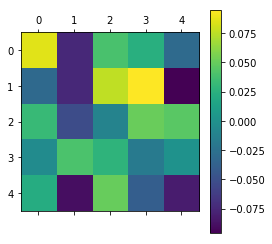

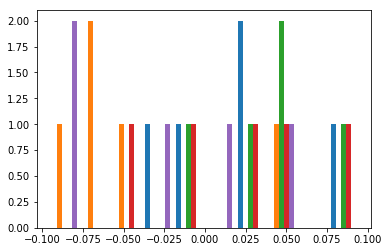

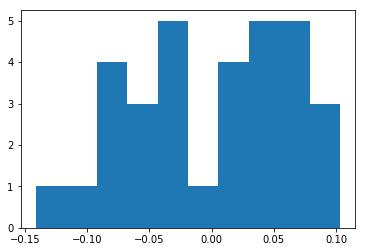

In [0]:
import matplotlib.pyplot as plt

layer =int(input('Enter the Layer: '))*2
fil = int(input('Enter the filter number: '))

print(all_parameters[layer][fil][0])

length = int(all_parameters[layer][fil][0].size**0.5)
plt.matshow(all_parameters[layer][fil][0].reshape(length,length))
plt.colorbar()
plt.show()

binwidth = 0.01

plt.hist(all_parameters[layer][fil][0])
plt.show()

plt.hist(all_parameters[layer+1])
plt.show()


###Visualizing Values as they pass through the model

In [0]:
# Loading the test data
data = datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

tensor([[ -75.1333, -353.2830,  -14.9619,  -85.3990, -936.0524, -361.3423,
            0.0000, -884.4292, -330.8306, -839.4867]], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


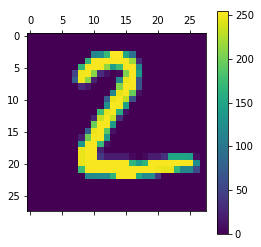

In [0]:
# Evaluating an Example
e = 1
model.train()
example = deepcopy(data.data[e]).unsqueeze(0).unsqueeze(0)

if args['cuda']:
    model.cuda()
    example = example.cuda()

example = Variable(example,volatile=True).float()
print(model(example).data)

plt.matshow(data.data[e])
plt.colorbar()

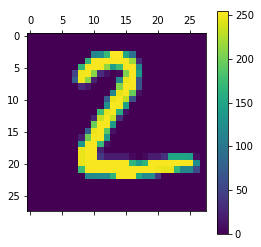

(24, 24)


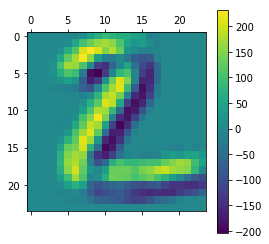

(24, 24)


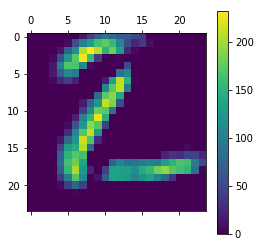

(20, 20)


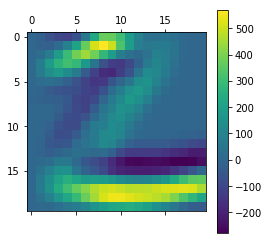

(10, 10)


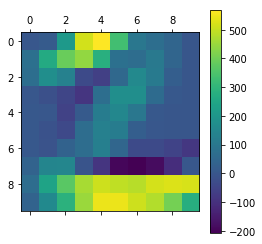

(10, 10)


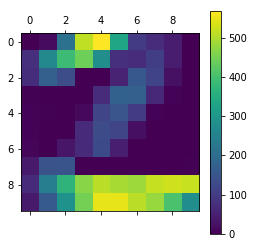

(10, 10)


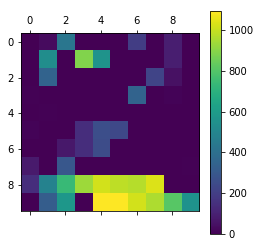

(6, 6)


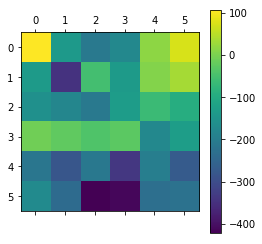

(3, 3)


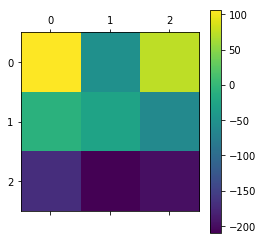

(3, 3)


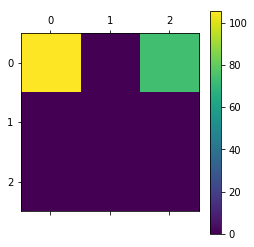

(3, 3)


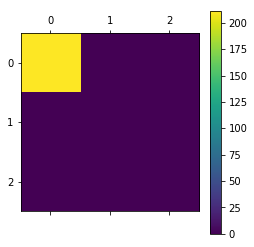

(64, 9)


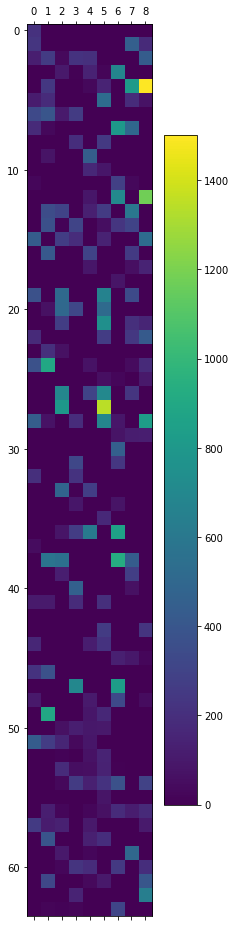

(16, 16)


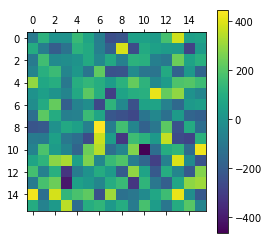

(16, 16)


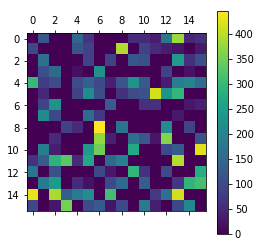

(16, 16)


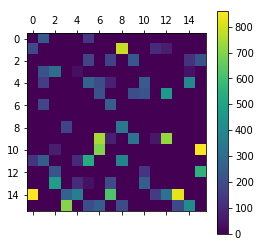

(5, 2)


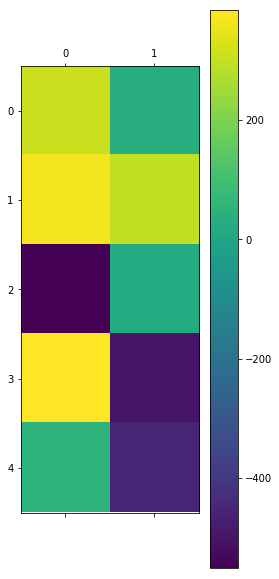

(5, 2)


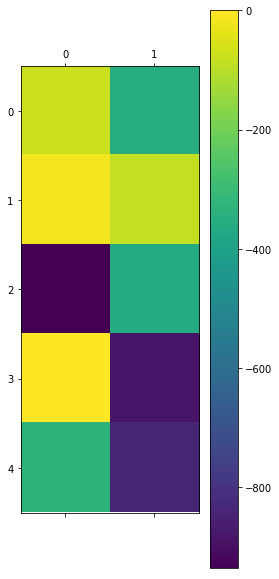

In [0]:
import numpy as np
img = plt.matshow(model.x.cpu().detach().numpy()[0][0])
plt.colorbar()
plt.show()

plt.matshow(model.after_conv1.cpu().detach().numpy()[0][0])
print(model.after_conv1.cpu().detach().numpy()[0][2].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_relu1.cpu().detach().numpy()[0][0])
print(model.after_relu1.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_conv2.cpu().detach().numpy()[0][0])
print(model.after_conv2.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_maxpool2.cpu().detach().numpy()[0][0])
print(model.after_maxpool2.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_relu2.cpu().detach().numpy()[0][0])
print(model.after_relu2.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()


plt.matshow(model.after_dropout2.cpu().detach().numpy()[0][0])
print(model.after_dropout2.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_conv3.cpu().detach().numpy()[0][0])
print(model.after_conv3.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_maxpool3.cpu().detach().numpy()[0][0])
print(model.after_maxpool3.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_relu3.cpu().detach().numpy()[0][0])
print(model.after_relu3.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

plt.matshow(model.after_dropout3.cpu().detach().numpy()[0][0])
print(model.after_dropout3.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()

x = model.after_reshape.cpu().detach().numpy().reshape(64,9)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()

x = model.after_fc4.cpu().detach().numpy().reshape(16,16)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()

x = model.after_relu4.cpu().detach().numpy().reshape(16,16)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()

x = model.after_dropout4.cpu().detach().numpy().reshape(16,16)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()

x = model.after_fc5.cpu().detach().numpy().reshape(5,2)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()

x = F.log_softmax(model.after_fc5, dim=1).cpu().detach().numpy().reshape(5,2)
plt.matshow(x)
print(x.shape)
plt.colorbar()
plt.show()


##Attributing Result to neurons and Data
print(model.after_conv3.cpu().detach().numpy()[0][0].shape)
plt.colorbar()
plt.show()


In [0]:
# Loading the test data
data = datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

tensor([[    0.0000, -1260.5658,  -454.7112,  -665.7850, -1311.0803,  -568.8503,
          -750.2554, -1009.5161,  -765.2604,  -955.6873]], device='cuda:0')


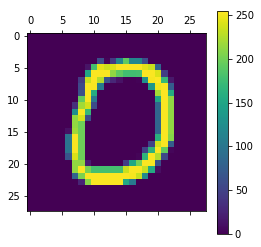

In [0]:
# Evaluating an Example
e = 10
model.eval()
example = []
example = deepcopy(data.data[e]).unsqueeze(0).unsqueeze(0)

if args['cuda']:
    model.cuda()
    example = example.cuda()

example = Variable(example).float()
example.requires_grad=True
print(model(example).data)

plt.matshow(data.data[e])
plt.colorbar()

model.after_fc5[0][8].backward()

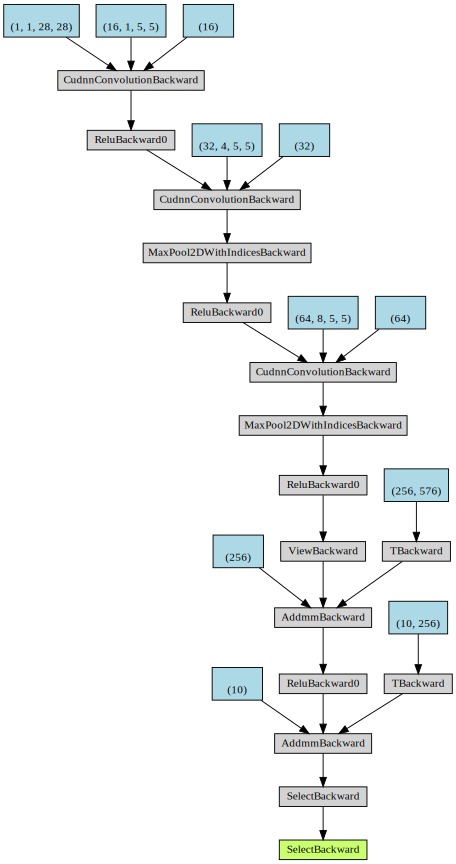

In [0]:
make_dot(model.after_fc5[0][4])

(28, 28)


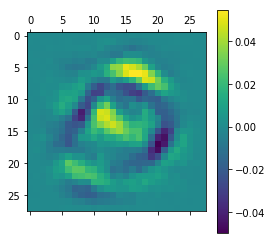

tensor([[    0.0000, -1262.8840,  -435.6823,  -638.3602, -1333.1941,  -546.8757,
          -764.7758, -1010.5435,  -733.4466,  -948.2434]], device='cuda:0')


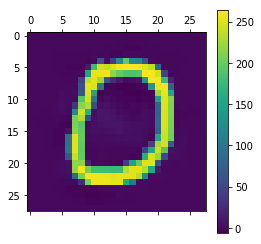

tensor([[ -488.2025, -1730.4186,  -180.5984,   -13.7419, -1986.1416,   -66.7559,
         -1335.6862, -1319.4044,     0.0000,  -966.4824]], device='cuda:0')


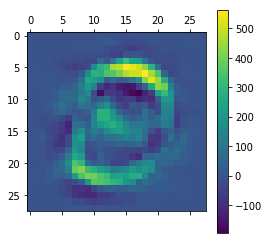

In [0]:
gradients = example.grad.cpu().detach().numpy()[0][0]
print(gradients.shape)


plt.matshow(gradients)
plt.colorbar()
plt.show()

example1 = Variable(example+example.grad*200,requires_grad=True)
print(model(example1).data)

example_np1 = example1.cpu().detach().numpy()

plt.matshow(example_np1[0][0])
plt.colorbar()
plt.show()

example2 = Variable(example+example.grad*6000,requires_grad=True)
print(model(example2).data)

example_np2 = example2.cpu().detach().numpy()

plt.matshow(example_np2[0][0])
plt.colorbar()
plt.show()

tensor([[    0.0000, -1260.5658,  -454.7112,  -665.7850, -1311.0803,  -568.8503,
          -750.2554, -1009.5161,  -765.2604,  -955.6873]], device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor

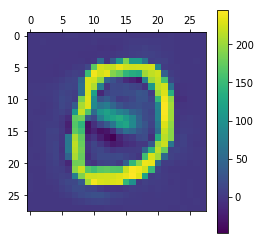

In [0]:
# performing a FGSM attack

# Evaluating an Example
e = 10
model.eval()
example = []
example = deepcopy(data.data[e]).unsqueeze(0).unsqueeze(0)

if args['cuda']:
    model.cuda()
    example = example.cuda()

example = Variable(example).float()
example.requires_grad=True
print(model(example).data)

pi = torch.argmax(model(example).data)
print(pi)

while True:  
    example = Variable(example).float()
    example.requires_grad=True
    p = torch.argmax(model(example).data)
    print(p)
    if pi != p:
      break
    
    p = p.data.cpu().detach().numpy().tolist()
    #print(p)
    
    #plt.matshow(data.data[e])
    #plt.colorbar()

    model.after_fc5[0][0].backward()

    #gradients = example.grad.cpu().detach().numpy()

    #plt.matshow(gradients)
    #plt.colorbar()
    #plt.show()

    example = Variable(example-example.grad*10,requires_grad=True)
    #print(model(example).data)

example_np1 = example.cpu().detach().numpy()


plt.matshow(example_np1[0][0])
plt.colorbar()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 4, 4, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 4, 4, 4, 4, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1

<function matplotlib.pyplot.show>

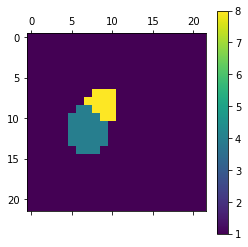

In [0]:
# moving white patch over the image
sizex = 5
sizey = 5
result = []
example = []
for x in range(28-sizex-1):
  result.append([])
  for y in range(28-sizey-1):
    # Evaluating an Example
    e = 89
    model.eval()
    example = deepcopy(data.data[e])

    for i in range(x,x+sizex):
      for j in range(y,y+sizey):
        example[i][j] = torch.max(example)

    if args['cuda']:
        model.cuda()
        example = example.cuda()

    example = Variable(example,volatile=True).float()
    prediction = model(example.unsqueeze(0).unsqueeze(0)).data.cpu().detach().numpy().tolist()[0]
    p = prediction.index(max(prediction))
    result[-1].append(p)
    
    #plt.matshow(example.cpu())
    #plt.colorbar()
    #plt.show()
print(result)

plt.matshow(np.array(result))
plt.colorbar()
plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


5


<function matplotlib.pyplot.show>

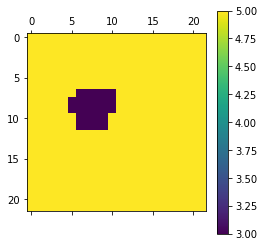

In [0]:
# moving black patch over the image
sizex = 5
sizey = 5
result = []
example = []
for x in range(28-sizex-1):
  result.append([])
  for y in range(28-sizey-1):
    # Evaluating an Example
    e = 15
    model.eval()
    example = deepcopy(data.data[e])

    for i in range(x,x+sizex):
      for j in range(y,y+sizey):
        example[i][j] = torch.min(example)

    if args['cuda']:
        model.cuda()
        example = example.cuda()

    example = Variable(example,volatile=True).float()
    prediction = model(example.unsqueeze(0).unsqueeze(0)).data.cpu().detach().numpy().tolist()[0]
    p = prediction.index(max(prediction))
    result[-1].append(p)
    
    #plt.matshow(example.cpu())
    #plt.colorbar()
    #plt.show()
print(p)

plt.matshow(np.array(result))
plt.colorbar()
plt.show